# Spatiotemporal mortality modelling using Gaussian process regression
Aim: model the death rate in each spatial unit (LSOA in London) over the years 2002-2017 for 19 age groups (0, 1-4, 5-9, 10-14, ..., 80-94, 85+). (Note this is simulated data due to the sensitivity of health records, and this dataset only covers 2004-2017.)

In [1]:
import gpflow
import pandas as pd
import numpy as np
import tensorflow as tf
from gpflow.ci_utils import ci_niter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
plt.style.use("ggplot")

In [3]:
tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10523416722882171618,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1860473412011330109
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18235557927867648444
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3750363136
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 9549078528883938367
 physical_device_desc: "device: 0, name: Quadro P1000, pci bus id: 0000:b0:00.0, compute capability: 6.1"]

## Load the data

In [4]:
mortality = pd.read_csv("mortality.csv")

In [5]:
mortality = mortality[[
    "LAD2011", "MSOA2011", "LSOA2011", "sex", "deaths", "population", "YEAR", "age", "coords.x1", "coords.x2"
]]

In [6]:
print(mortality.shape)
mortality.head()

(2572220, 10)


,LAD2011,MSOA2011,LSOA2011,sex,deaths,population,YEAR,age,coords.x1,coords.x2
0,E09000001,E02000001,E01000001,1,0,3,2004,0.056495,532150.839566,181617.460916
1,E09000001,E02000001,E01000001,1,0,17,2004,2.638939,532150.839566,181617.460916
2,E09000001,E02000001,E01000001,1,0,16,2004,7.500000,532150.839566,181617.460916
3,E09000001,E02000001,E01000001,1,0,8,2004,12.500000,532150.839566,181617.460916
4,E09000001,E02000001,E01000001,1,0,10,2004,17.652159,532150.839566,181617.460916


## Create training and test sets

Work on men only for now

In [7]:
mortality_m = mortality[mortality["sex"] == 1]

Test on all the data coordinates

In [8]:
test_x = mortality_m[["coords.x1", "coords.x2", "YEAR", "age"]]
test_x = test_x.apply(lambda x: (x - x.mean()) / x.std())
test_x = test_x.values

Only train on data with non-negative populations. Zero population strata provide no information and will not work with log link offset in the likelihood.

In [9]:
mortality_m = mortality_m[mortality_m["population"] != 0]
mortality_m["death rate"] = mortality_m["deaths"]/mortality_m["population"]
mortality_m

,LAD2011,MSOA2011,LSOA2011,sex,deaths,population,YEAR,age,coords.x1,coords.x2,death rate
0,E09000001,E02000001,E01000001,1,0,3,2004,0.056495,532150.839566,181617.460916,0.000000
1,E09000001,E02000001,E01000001,1,0,17,2004,2.638939,532150.839566,181617.460916,0.000000
2,E09000001,E02000001,E01000001,1,0,16,2004,7.500000,532150.839566,181617.460916,0.000000
3,E09000001,E02000001,E01000001,1,0,8,2004,12.500000,532150.839566,181617.460916,0.000000
4,E09000001,E02000001,E01000001,1,0,10,2004,17.652159,532150.839566,181617.460916,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2572196,E09000011,E02006931,E01033746,1,3,42,2017,67.631902,538053.851750,177045.460068,0.071429
2572197,E09000011,E02006931,E01033746,1,0,33,2017,72.413336,538053.851750,177045.460068,0.000000
2572198,E09000011,E02006931,E01033746,1,2,23,2017,77.369979,538053.851750,177045.460068,0.086957
2572199,E09000011,E02006931,E01033746,1,6,18,2017,82.260847,538053.851750,177045.460068,0.333333


In [10]:
train_x = mortality_m[["YEAR", "age", "coords.x1", "coords.x2"]]
# rescale the columns because GP regression works better when the mean is around zero (standardise)
train_x = train_x.apply(lambda x: (x - x.mean()) / x.std())
train_x = train_x.values

train_y = mortality_m[["death rate"]]
train_y = train_y.values

In [11]:
# print("Train: ", train_x.shape, "Test: ", test_x.shape)
print("Train: ", train_x.shape)

Train:  (1282405, 4)


## 1. Simple GPFlow regression model
Let's ignore the Poisson/Negative Binonmial likelihood for now and just get a Stochastic Variational Gaussian Process (SVGP) regression setup with a Gaussian noise model likelihood working.

In [13]:
M = 500  # Number of inducing locations -- will need to optimise this
N = train_x.shape[0]
# kernel = gpflow.kernels.Matern52()

# SPECIFY KERNEL
# dimension:
# - 0 -- YEAR (Matern52)
# - 1 -- age (SE as smooth)
# - 2, 3 -- space (Matern52), but same lengthscale
# kernel = gpflow.kernels.Matern52(
#     active_dims=[0], lengthscales=1
# ) + gpflow.kernels.SquaredExponential(
#     active_dims=[1], lengthscales=1
# ) + gpflow.kernels.Matern52(
#     active_dims=[2,3], lengthscales=1
# )
kernel = gpflow.kernels.Matern52(
    active_dims=[0], lengthscales=1
) * gpflow.kernels.SquaredExponential(
    active_dims=[1], lengthscales=1
) * gpflow.kernels.Matern52(
    active_dims=[2,3], lengthscales=1
)
Z = train_x[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

In [14]:
m

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(500, 4)",float64,"[[-1.61494975, -1.56259323, 0.133074..."
SVGP.q_mu,Parameter,,,True,"(500, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 500, 500)",float64,"[[[1., 0., 0...."


In [15]:
minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).repeat().shuffle(N)
train_iter = iter(train_dataset.batch(minibatch_size))

Text(0, 0.5, 'pred_y')

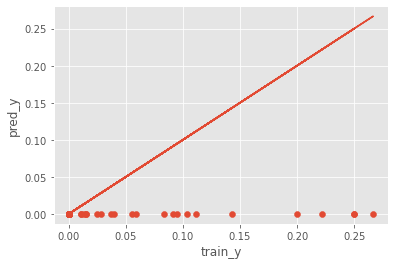

In [16]:
pY, pYv = m.predict_y(train_x[:100, :])
plt.scatter(train_y[:100], pY)
plt.plot(train_y[:100], train_y[:100])
plt.xlabel("train_y")
plt.ylabel("pred_y")

# initially all 0

In [41]:
# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, False)

def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.repeat().batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in tqdm(range(iterations)):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

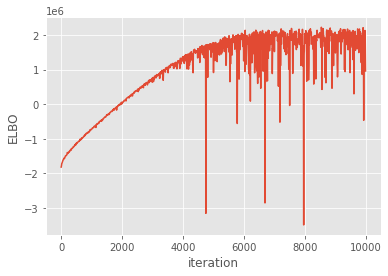

In [18]:
maxiter = ci_niter(10000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [19]:
m

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.09499668718905024
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.7027125860025243
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.09499668718905031
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.8345708106967622
SVGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.09499668718905124
SVGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,5.732502198224077
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.003987538262513178
SVGP.inducing_variable.Z,Parameter,,,False,"(500, 4)",float64,"[[-1.61494975, -1.56259323, 0.133074..."
SVGP.q_mu,Parameter,,,True,"(500, 1)",float64,[[5.84862548e-02...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 500, 500)",float64,"[[[3.06380351e-02, 0.00000000e+00, 0.00000000e+00..."


In [1]:
pY, pYv = m.predict_y(train_x[:100, :])
plt.scatter(train_y[:100], pY)
plt.plot(train_y[:100], train_y[:100])
plt.xlabel("train_y")
plt.ylabel("pred_y")

NameError: name 'm' is not defined

## 2. Poisson GPFlow regression model
Poisson likelihood linking deaths to an underlying Gaussian process (log-Gaussian Cox Process). This needs to be carefully offset by a mean function of the log population for each stratum.

In [61]:
train_x = mortality_m[["YEAR", "age", "coords.x1", "coords.x2"]]
# rescale the columns because GP regression works better when the mean is around zero (standardise)
train_x = train_x.apply(lambda x: (x - x.mean()) / x.std())
train_x = train_x.values

train_y = mortality_m[["deaths"]]
train_y = train_y.values

In [63]:
# offset  = np.log(mortality_m[["population"]].values)
# train_x = np.append(train_x, offset, axis=1)
# train_x

In [64]:
M = 500  # Number of inducing locations -- will need to optimise this
N = train_x.shape[0]

In [65]:
# SPECIFY KERNEL
# dimension:
# - 0 -- YEAR (Matern52)
# - 1 -- age (SE as smooth)
# - 2, 3 -- space (Matern52), but same lengthscale
kernel = gpflow.kernels.Matern52(
    active_dims=[0], lengthscales=1
) * gpflow.kernels.SquaredExponential(
    active_dims=[1], lengthscales=1
) * gpflow.kernels.Matern52(
    active_dims=[2,3], lengthscales=1
)

In [50]:
# SPECIFY MEAN FUNCTION
meanf = gpflow.mean_functions.Identity()

In [75]:
Z = train_x[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Poisson(), Z, num_data=N)#, mean_function = meanf)

In [76]:
m

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(500, 4)",float64,"[[-1.61494975, -1.56259323, 0.133074..."
SVGP.q_mu,Parameter,,,True,"(500, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 500, 500)",float64,"[[[1., 0., 0...."


In [77]:
minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).repeat().shuffle(N)
train_iter = iter(train_dataset.batch(minibatch_size))

In [78]:
# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, False)

In [79]:
maxiter = ci_niter(10000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

TypeError: in user code:

    <ipython-input-41-5a1d49fbd197>:19 optimization_step  *
        optimizer.minimize(training_loss, model.trainable_variables)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/gpflow/models/training_mixins.py:86 training_loss  *
        return self._training_loss(data)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/gpflow/models/model.py:57 _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/gpflow/models/svgp.py:138 maximum_log_likelihood_objective  *
        return self.elbo(data)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/gpflow/models/svgp.py:148 elbo  *
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/gpflow/likelihoods/base.py:280 variational_expectations  *
        ret = self._variational_expectations(Fmu, Fvar, Y)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/gpflow/likelihoods/scalar_continuous.py:59 _variational_expectations  *
        - 0.5 * ((Y - Fmu) ** 2 + Fvar) / self.variance,
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:527 subtract
        return gen_math_ops.sub(x, y, name)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py:10466 sub
        "Sub", x=x, y=y, name=name)
    /rds/general/user/tar15/home/anaconda3/envs/mortGP/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:506 _apply_op_helper
        inferred_from[input_arg.type_attr]))

    TypeError: Input 'y' of 'Sub' Op has type float64 that does not match type int64 of argument 'x'.


In [ ]:
m

In [ ]:
pY, pYv = m.predict_y(train_x[:100, :])
plt.scatter(train_y[:100], pY)
plt.plot(train_y[:100], train_y[:100])
plt.xlabel("train_y")
plt.ylabel("pred_y")